<a href="https://colab.research.google.com/github/rhozon/Banca-FAE/blob/master/Notebook_R_Forecasting_Scenarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook de geração de três cenários para os retornos de cada ativo de um portfólio pré-selecionado de commodities agrícolas**



In [81]:
# Instala os pacotes do R necessários

install.packages(
  c(
    "tidyverse",
    "tsibble",
    "fpp3",
    "quantmod",
    "timetk",
    "openxlsx"
  ),
  repos = "https://cloud.r-project.org"
)

cat("======================================================================", "\n")

cat("Fim da instalação dos pacotes do R", "\n")

cat("======================================================================", "\n")


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Fim da instalação dos pacotes do R 


In [82]:

# Chama os pacotes do R

suppressPackageStartupMessages({
  library(tidyverse)
  library(tsibble)
  library(fpp3)
  library(quantmod)
  library(timetk)
  library(openxlsx)
})

cat("======================================================================", "\n")

cat("Carregamento dos pacotes do R, finalizada", "\n")

cat("======================================================================", "\n")

Carregamento dos pacotes do R, finalizada 


## Baixando os tickers do meu portfólio pré-selecionado

In [83]:

# Mude para a lista dos seus tickers via Yahoo!Finances aqui!

tickers <- c(
  "ZC=F", # Corn Futures
  "ZO=F", # Wheat Futures
  "KE=F", # Futuros KC HRW Wheat Futures
  #         "ZR=F", # Rough Rice Futures
  "GF=F", # Feeder Cattle Futures
  "ZS=F", # SoyMeal Futures
  "ZM=F", # Futuros farelo soja
  "ZL=F"  # SoyBeans Futures
)

cat("======================================================================", "\n")

cat("Mudou pra sua lista de tickers ?", "\n")

cat("======================================================================", "\n")


Mudou pra sua lista de tickers ? 


In [84]:

# Baixa somente os preços de fechamento

# não imprimir warnings
options(warn = -1)

portfolioPrices <- NULL
for ( Ticker in tickers )
  portfolioPrices <- cbind(
    portfolioPrices,
    quantmod::getSymbols.yahoo(
      Ticker,
      from = "2019-01-01",
      auto.assign = FALSE
    )[,4]
  )

portfolioPrices <- portfolioPrices[apply(portfolioPrices, 1, function(x) all(!is.na(x))),]

# Aqui renomeio cada ticker pelo nome da commoditie... (faça o mesmo se julgar necessário)
colnames(portfolioPrices) <- c(
  "corn_fut",
  "wheat_fut",
  "KCWheat_fut",
  # "rice_fut",
  "Feeder_Cattle",
  "soymeal_fut",
  "soyF_fut",
  "soybeans_fut"
)


In [85]:

# Transforma e visualiza a ultima data baixada de negociação

log_returns <- log(portfolioPrices) - log(lag(portfolioPrices))
log_returns <- na.omit(log_returns)
log_returns <- log_returns |> timetk::tk_tbl(preserve_index = TRUE, rename_index = "date")

tail(log_returns) # Visualizando quando que vem o último dia de trade...



date,corn_fut,wheat_fut,KCWheat_fut,Feeder_Cattle,soymeal_fut,soyF_fut,soybeans_fut
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-04-14,-0.010766574,0.002888089,-0.022702956,0.010031050,-0.0009594628,-0.008379469,-0.021992961
2025-04-15,-0.007762005,-0.011602741,-0.004060461,0.004589391,-0.0055348475,-0.009808953,0.021570556
2025-04-16,0.006214417,0.013763347,0.009000961,0.001985112,0.0026509234,0.008461719,0.003164177
2025-04-17,-0.004138651,0.025569575,-0.000896459,0.011657920,-0.0021684143,-0.003714359,0.008180421
2025-04-21,-0.001037344,-0.002106003,-0.012181518,-0.027036887,-0.0067764054,-0.009175977,-0.001045025
2025-04-22,-0.012532801,0.005606181,-0.008662010,0.004891245,0.0053281792,-0.003419976,-0.005031412


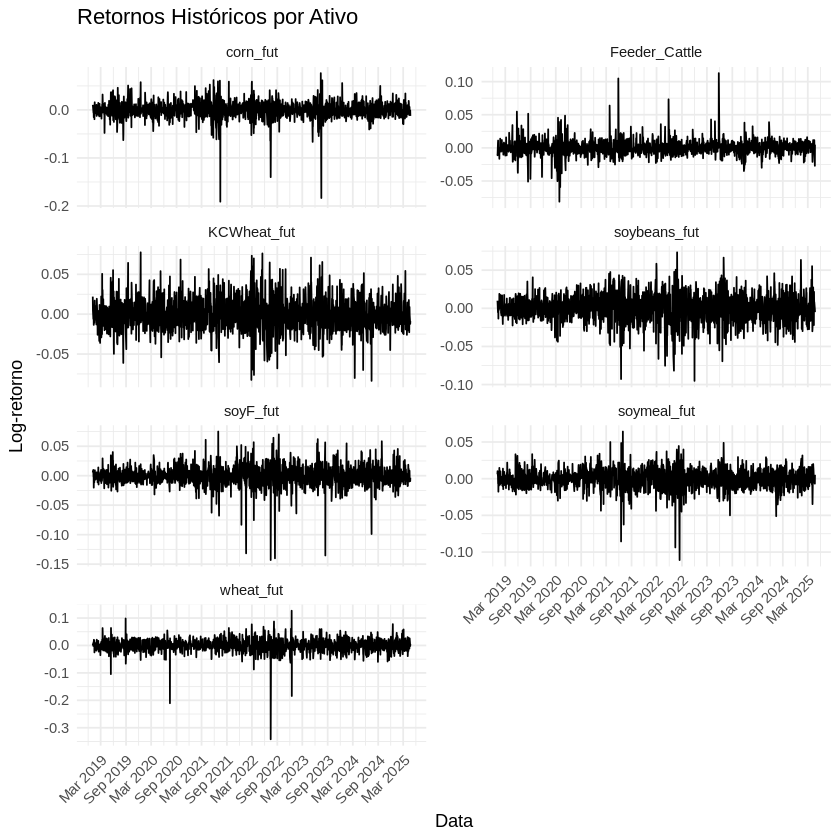

In [86]:
# Prepara dados no formato long com coluna date
df_long <- log_returns %>%
  tidyr::pivot_longer(
    cols      = -date,
    names_to  = "Variables",
    values_to = "Value"
  )

# Gráfico estático com ggplot2
library(ggplot2)

ggplot(df_long, aes(x = date, y = Value)) +
  geom_line() +
  facet_wrap(~ Variables, scales = "free_y", ncol = 2) +
  labs(
    title = "Retornos Históricos por Ativo",
    x = "Data",
    y = "Log-retorno"
  ) +
  scale_x_date(
    date_breaks = "6 months",
    date_labels = "%b %Y"
  ) +
  theme_minimal() +
  theme(
    strip.background = element_rect(fill = "white", colour = "white"),
    axis.text.x     = element_text(angle = 45, hjust = 1)
  )

In [87]:
# Pivoteia o conjunto de dados

long_returns <- log_returns %>%
  pivot_longer(-date, names_to = "asset", values_to = "ret")

tsbl_returns <- long_returns %>%
  as_tsibble(key = asset, index = date)


In [88]:

# Roda o modelo com regressão com quebras pros ativos
models_all <- tsbl_returns %>%
  model(
    Regr_Quebras = TSLM(ret ~ trend(knots = c(2020, 2022, 2024))) # Insira tres anos em que vc nota as quebras nos seus retornos (vide plot anterior)
  )

sims_all <- models_all %>%
  generate(h = 30, times = 3, bootstrap = TRUE)


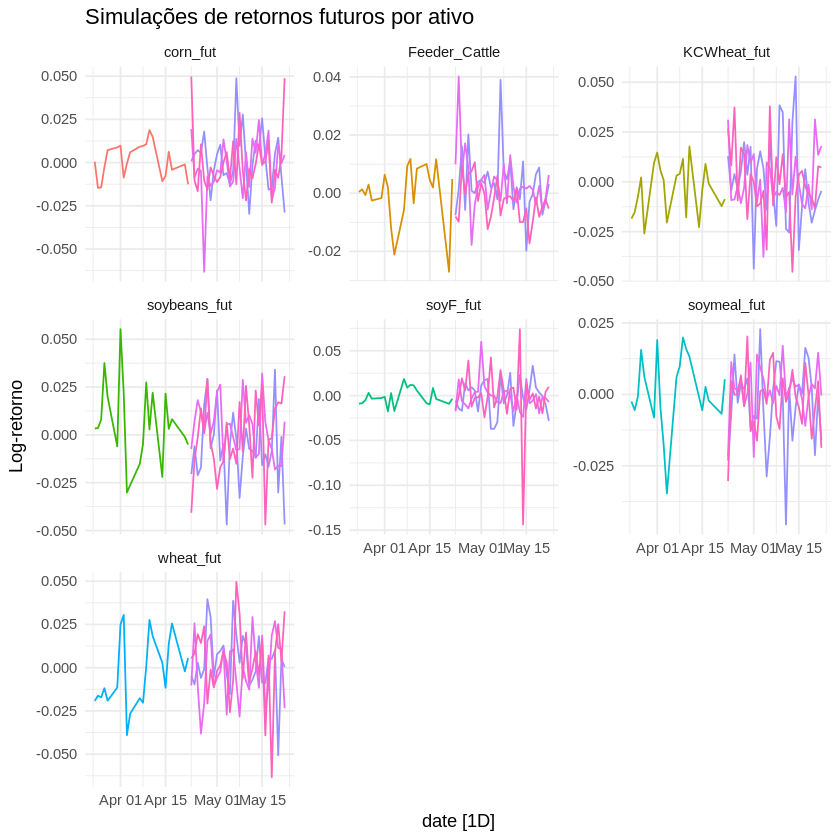

In [89]:

# Plota e visualiza os forecasts gerados (3 cenários pra cada ativo)
autoplot(
  tsbl_returns %>% filter_index("2025-03-22" ~ .), # Gráfico de aprox. um mês antes dos retornos x valores projetados (3 cenários)
  ret
) +
  geom_line(
    aes(y = .sim, colour = as.factor(.rep)),
    data = sims_all
  ) +
  facet_wrap(~ asset, scales = "free_y") +
  labs(
    title = "Simulações de retornos futuros por ativo",
    y = "Log-retorno"
  ) +
  guides(colour = "none") +
  theme_minimal()


In [90]:

# percorra cada ativo e crie um workbook separadamente
assets <- unique(sims_all$asset)
dir.create("forecasts", showWarnings = FALSE)

for (a in assets) {
  df <- sims_all %>%
    filter(asset == a) %>%
    select(date, .rep, .sim) %>%
    pivot_wider(names_from = .rep, values_from = .sim, names_prefix = "sim_")

  wb <- createWorkbook()
  addWorksheet(wb, a)               # nome da sheet = código do ativo
  writeData(wb, sheet = a, x = df)  # escreve todo o data.frame

  saveWorkbook(
    wb,
    file = file.path("forecasts", paste0(a, "_forecast.xlsx")),
    overwrite = TRUE
  )
}

for(a in assets) {
  df <- sims_all %>%
    filter(asset == a) %>%
    select(date, .rep, .sim) %>%
    pivot_wider(names_from = .rep, values_from = .sim, names_prefix = "sim_")

  write.csv2(
    df,
    file = file.path("forecasts", paste0(a, "_forecast.csv")),
    row.names = FALSE
  )
}


## Baixando os dados gerados em formato Excel correto...

In [91]:

cat("==================================================================================================================================", "\n")

cat("Agora clique no simbolo da pastinha aqui no Colab (no menu à esquerda) e baixe o arquivo chamado forecasts.zip, ou então...", "\n")

cat("==================================================================================================================================", "\n")

# primeiro, crie o ZIP (se ainda não tiver feito)
utils::zip(
  zipfile = "forecasts.zip",
  files   = list.files("forecasts", full.names = TRUE, recursive = TRUE)
)

# agora, exiba um link de download clicável
if (!requireNamespace("IRdisplay", quietly = TRUE)) {
  install.packages("IRdisplay", repos = "https://cloud.r-project.org")
}
library(IRdisplay)

display_html('
  <div style="font-size:16px; margin: 10px 0;">
    <a href="forecasts.zip" download
       style="padding:8px 12px; background:#4CAF50; color:white;
              text-decoration:none; border-radius:4px;">
      📥 Clique aqui para baixar forecasts.zip
    </a>
  </div>
')


Agora clique no simbolo da pastinha aqui no Colab (no menu à esquerda) e baixe o arquivo chamado forecasts.zip, ou então... 


📥 Clique aqui para baixar forecasts.zip